# Delivery Duration Prediction (Stratascratch)

In [1]:
from IPython.display import Markdown, display

import pandas as pd
import numpy as np
np.random.seed(42)
rng = np.random.default_rng(42)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pathlib import Path
data_path = Path('./data')

### dataframe

In [2]:
df = pd.read_csv(data_path / 'historical_data.csv')

In [3]:
df

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,2956,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0,251,331.0
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,2956,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0,251,915.0
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,2956,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0,251,795.0
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,3630,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0,446,384.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

### initial data processing 

In [5]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [6]:
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

#### handeling nulls

In [7]:
def nulls_data(df): 

    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    percent_null = (null_counts/len(df)) * 100
    null_table = pd.DataFrame({'column': null_counts.index, 'data type': df[null_counts.index].dtypes, 'number of nulls': null_counts.values, 
                               'precent null': percent_null.values})
    null_table = null_table.sort_values(by='precent null', ascending=False).reset_index(drop=True)

    return null_table

In [8]:
nulls_data(df)

,column,data type,number of nulls,precent null
0,total_onshift_dashers,float64,16262,8.236927
1,total_busy_dashers,float64,16262,8.236927
2,total_outstanding_orders,float64,16262,8.236927
3,store_primary_category,object,4760,2.411006
4,order_protocol,float64,995,0.503981
5,market_id,float64,987,0.499929
6,estimated_store_to_consumer_driving_duration,float64,526,0.266426
7,actual_delivery_time,datetime64[ns],7,0.003546


In [9]:
# checking if the null values in these columns occurr all on the same rows
df.loc[df['total_onshift_dashers'].isnull() & df['total_busy_dashers'].isnull() & df['total_outstanding_orders'].isnull()]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
160,6.0,2015-02-06 01:11:56,2015-02-06 01:42:51,976,breakfast,2.0,2,575,2,225,350,NaN,NaN,NaN,251,671.0
161,6.0,2015-02-14 02:07:47,2015-02-14 03:17:37,976,breakfast,2.0,5,1415,3,185,675,NaN,NaN,NaN,251,893.0
162,6.0,2015-01-31 21:58:30,2015-01-31 22:55:32,976,breakfast,2.0,1,650,1,650,650,NaN,NaN,NaN,251,479.0
163,6.0,2015-02-08 03:28:59,2015-02-08 05:32:11,976,breakfast,2.0,5,1550,5,225,700,NaN,NaN,NaN,251,1104.0
164,6.0,2015-01-23 19:29:17,2015-01-23 20:25:25,976,breakfast,2.0,6,1110,5,185,185,NaN,NaN,NaN,251,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197196,3.0,2015-02-10 19:55:29,2015-02-10 20:33:13,5382,indian,2.0,3,1792,3,163,1177,NaN,NaN,NaN,251,725.0
197197,3.0,2015-02-06 03:05:38,2015-02-06 03:58:16,5382,indian,2.0,8,2923,5,50,1199,NaN,NaN,NaN,251,683.0
197198,3.0,2015-01-23 03:57:56,2015-01-23 04:43:17,5382,indian,2.0,3,3297,3,799,1299,NaN,NaN,NaN,251,725.0
197199,3.0,2015-01-24 03:15:41,2015-01-24 04:04:19,5382,indian,2.0,4,2776,4,179,1099,NaN,NaN,NaN,251,820.0


In [10]:
dropped_df = df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders'])

In [11]:
# there is no overlap between the nulls in those three categories and the nulls in other categories
nulls_data(dropped_df)

,column,data type,number of nulls,precent null
0,store_primary_category,object,4760,2.411006
1,order_protocol,float64,995,0.503981
2,market_id,float64,987,0.499929
3,estimated_store_to_consumer_driving_duration,float64,526,0.266426
4,actual_delivery_time,datetime64[ns],7,0.003546


In [12]:
marketid_mode = df.dropna(subset=['store_id', 'market_id']).groupby('store_id')['market_id'].agg(lambda x: x.mode().values[0] if len(x.mode()) > 0 else None)

In [13]:
marketid_mode

store_id
1       3.0
2       1.0
3       3.0
4       1.0
5       6.0
       ... 
6983    1.0
6984    6.0
6985    1.0
6986    4.0
6987    3.0
Name: market_id, Length: 6740, dtype: float64

In [14]:
df['market_id'] = df['market_id'].fillna(df['store_id'].map(marketid_mode))

In [15]:
df = df.dropna(subset=['market_id'])

In [16]:
category_mode = df.groupby('store_id')['store_primary_category'].agg(pd.Series.mode)

In [17]:
df.loc[:, 'store_primary_category'] = df['store_id'].map(category_mode)

In [18]:
nulls_data(df)

,column,data type,number of nulls,precent null
0,total_onshift_dashers,float64,16261,8.236546
1,total_busy_dashers,float64,16261,8.236546
2,total_outstanding_orders,float64,16261,8.236546
3,order_protocol,float64,992,0.502469
4,estimated_store_to_consumer_driving_duration,float64,526,0.266430
5,actual_delivery_time,datetime64[ns],7,0.003546


In [19]:
df['created_at'].dt.year.value_counts()

created_at
2015    197424
2014         1
Name: count, dtype: int64

In [20]:
df['created_at'].dt.month.value_counts()

created_at
2     128942
1      68482
10         1
Name: count, dtype: int64

In [21]:
# this is seems wrong. Check for other date descrpencies
df[df['created_at'].dt.month == 10]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
2690,1.0,2014-10-19 05:24:15,2015-01-25 19:11:54,3560,italian,1.0,1,1695,1,1595,1595,NaN,NaN,NaN,446,412.0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197425 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     197425 non-null  float64       
 1   created_at                                    197425 non-null  datetime64[ns]
 2   actual_delivery_time                          197418 non-null  datetime64[ns]
 3   store_id                                      197425 non-null  int64         
 4   store_primary_category                        197425 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197425 non-null  int64         
 7   subtotal                                      197425 non-null  int64         
 8   num_distinct_items                            197425 non-nu

In [23]:
df.loc[:, 'actual_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() 

/var/folders/t5/9mgk68q96sscb1r6k963qqp40000gn/T/ipykernel_77577/3486958882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'actual_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()


In [24]:
df['actual_duration']

0         3779.0
1         4024.0
2         1781.0
3         3075.0
4         2390.0
           ...  
197423    3907.0
197424    3383.0
197425    3008.0
197426    3907.0
197427    2228.0
Name: actual_duration, Length: 197425, dtype: float64

In [25]:
df.loc[:, 'day'] = df['created_at'].dt.day_of_week

/var/folders/t5/9mgk68q96sscb1r6k963qqp40000gn/T/ipykernel_77577/1717547114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'day'] = df['created_at'].dt.day_of_week


In [26]:
df.loc[:, 'hour'] = df['created_at'].dt.hour

/var/folders/t5/9mgk68q96sscb1r6k963qqp40000gn/T/ipykernel_77577/273154434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'hour'] = df['created_at'].dt.hour


In [27]:
df.groupby(['day', 'hour'])['total_onshift_dashers'].mean().reset_index()

,day,hour,total_onshift_dashers
0,0,0,35.335277
1,0,1,54.597839
2,0,2,61.237973
3,0,3,57.917838
4,0,4,42.135849
...,...,...,...
119,6,19,26.423913
120,6,20,34.626506
121,6,21,34.471331
122,6,22,31.369724


In [28]:
onshift_null_index = df.loc[df['total_onshift_dashers'].isnull()]

In [29]:
onshift_null_index

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_duration,day,hour
160,6.0,2015-02-06 01:11:56,2015-02-06 01:42:51,976,breakfast,2.0,2,575,2,225,350,NaN,NaN,NaN,251,671.0,1855.0,4,1
161,6.0,2015-02-14 02:07:47,2015-02-14 03:17:37,976,breakfast,2.0,5,1415,3,185,675,NaN,NaN,NaN,251,893.0,4190.0,5,2
162,6.0,2015-01-31 21:58:30,2015-01-31 22:55:32,976,breakfast,2.0,1,650,1,650,650,NaN,NaN,NaN,251,479.0,3422.0,5,21
163,6.0,2015-02-08 03:28:59,2015-02-08 05:32:11,976,breakfast,2.0,5,1550,5,225,700,NaN,NaN,NaN,251,1104.0,7392.0,6,3
164,6.0,2015-01-23 19:29:17,2015-01-23 20:25:25,976,breakfast,2.0,6,1110,5,185,185,NaN,NaN,NaN,251,584.0,3368.0,4,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197196,3.0,2015-02-10 19:55:29,2015-02-10 20:33:13,5382,indian,2.0,3,1792,3,163,1177,NaN,NaN,NaN,251,725.0,2264.0,1,19
197197,3.0,2015-02-06 03:05:38,2015-02-06 03:58:16,5382,indian,2.0,8,2923,5,50,1199,NaN,NaN,NaN,251,683.0,3158.0,4,3
197198,3.0,2015-01-23 03:57:56,2015-01-23 04:43:17,5382,indian,2.0,3,3297,3,799,1299,NaN,NaN,NaN,251,725.0,2721.0,4,3
197199,3.0,2015-01-24 03:15:41,2015-01-24 04:04:19,5382,indian,2.0,4,2776,4,179,1099,NaN,NaN,NaN,251,820.0,2918.0,5,3


In [30]:
df.loc[:, 'total_onshift_dashers'] = df.groupby(['day', 'hour'])['total_onshift_dashers'].transform(lambda x: x.fillna(x.mean()))

In [31]:
df.loc[(df.index.isin(onshift_null_index.index)) & (df['day'] == 0)]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_duration,day,hour
514,6.0,2015-02-09 05:22:41,2015-02-09 05:51:35,5674,korean,1.0,2,2390,2,1095,1295,21.046250,NaN,NaN,446,626.0,1734.0,0,5
534,2.0,2015-02-09 19:19:38,2015-02-09 19:48:13,2716,sandwich,3.0,2,1588,2,479,479,28.539789,NaN,NaN,251,169.0,1715.0,0,19
1190,6.0,2015-02-09 23:11:22,2015-02-10 00:14:08,4476,soup,3.0,3,1950,3,200,625,14.494635,NaN,NaN,251,280.0,3766.0,0,23
1584,6.0,2015-02-09 19:55:39,2015-02-09 21:57:05,4476,soup,3.0,5,2250,2,225,625,28.539789,NaN,NaN,251,763.0,7286.0,0,19
1585,6.0,2015-01-26 19:47:12,2015-01-26 20:45:21,4476,soup,3.0,3,1800,3,400,625,28.539789,NaN,NaN,251,407.0,3489.0,0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196700,6.0,2015-02-09 02:56:41,2015-02-09 03:49:03,96,vietnamese,1.0,1,950,1,950,950,61.237973,NaN,NaN,446,509.0,3142.0,0,2
196761,3.0,2015-02-16 02:09:11,2015-02-16 03:11:34,1507,pizza,4.0,2,2590,1,1295,1295,61.237973,NaN,NaN,446,393.0,3743.0,0,2
196762,3.0,2015-01-26 02:26:16,2015-01-26 02:56:35,1507,pizza,1.0,3,2785,3,595,1295,61.237973,NaN,NaN,446,327.0,1819.0,0,2
196960,3.0,2015-01-26 19:39:09,2015-01-26 21:28:21,629,greek,3.0,2,1018,2,259,759,28.539789,NaN,NaN,251,505.0,6552.0,0,19


In [32]:
nulls_data(df)

,column,data type,number of nulls,precent null
0,total_busy_dashers,float64,16261,8.236546
1,total_outstanding_orders,float64,16261,8.236546
2,order_protocol,float64,992,0.502469
3,estimated_store_to_consumer_driving_duration,float64,526,0.266430
4,actual_delivery_time,datetime64[ns],7,0.003546
5,actual_duration,float64,7,0.003546


In [33]:
df.loc[:, 'total_busy_dashers'] = df.groupby(['day', 'hour'])['total_busy_dashers'].transform(lambda x: x.fillna(x.mean()))

In [34]:
df.loc[:, 'total_outstanding_orders'] = df.groupby(['day', 'hour'])['total_busy_dashers'].transform(lambda x: x.fillna(x.mean()))

In [35]:
protocol_mode = df.groupby('store_id')['order_protocol'].agg(pd.Series.mode)

In [36]:
df.loc[:, 'order_protocol'] = df.groupby(['day', 'hour'])['order_protocol'].transform(lambda x: x.fillna(x.mean()))

In [37]:
df.loc[:, 'day and hour'] = df['day'] + df['hour']

/var/folders/t5/9mgk68q96sscb1r6k963qqp40000gn/T/ipykernel_77577/3144672976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'day and hour'] = df['day'] + df['hour']


In [38]:
df['day and hour']

0         26
1         22
2         23
3         22
4          8
          ..
197423     1
197424     4
197425     9
197426    24
197427    25
Name: day and hour, Length: 197425, dtype: int32

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197425 entries, 0 to 197427
Data columns (total 20 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     197425 non-null  float64       
 1   created_at                                    197425 non-null  datetime64[ns]
 2   actual_delivery_time                          197418 non-null  datetime64[ns]
 3   store_id                                      197425 non-null  int64         
 4   store_primary_category                        197425 non-null  object        
 5   order_protocol                                197425 non-null  float64       
 6   total_items                                   197425 non-null  int64         
 7   subtotal                                      197425 non-null  int64         
 8   num_distinct_items                            197425 non-nu

In [40]:
df['market_id']

0         1.0
1         2.0
2         3.0
3         3.0
4         3.0
         ... 
197423    1.0
197424    1.0
197425    1.0
197426    1.0
197427    1.0
Name: market_id, Length: 197425, dtype: float64

In [41]:
heatmap_corr = df[['market_id', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'day', 
                   'hour', 'estimated_store_to_consumer_driving_duration']].corr()

In [42]:
heatmap_corr

,market_id,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,day,hour,estimated_store_to_consumer_driving_duration
market_id,1.000000,0.059950,0.054121,0.054121,-0.002412,-0.013684,0.006678
total_onshift_dashers,0.059950,1.000000,0.944775,0.944775,0.102209,-0.384542,0.043172
total_busy_dashers,0.054121,0.944775,1.000000,1.000000,0.085197,-0.360072,0.041824
total_outstanding_orders,0.054121,0.944775,1.000000,1.000000,0.085197,-0.360072,0.041824
day,-0.002412,0.102209,0.085197,0.085197,1.000000,0.018900,0.007788
hour,-0.013684,-0.384542,-0.360072,-0.360072,0.018900,1.000000,-0.023275
estimated_store_to_consumer_driving_duration,0.006678,0.043172,0.041824,0.041824,0.007788,-0.023275,1.000000


<Axes: >

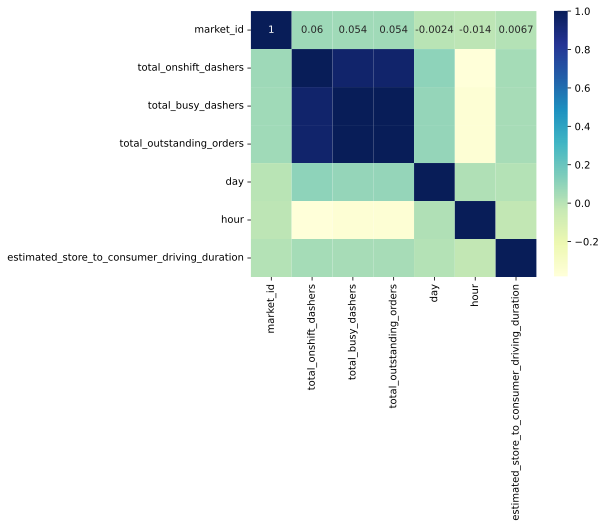

In [43]:
sns.heatmap(heatmap_corr, annot=True, cmap='YlGnBu', cbar=True)

In [44]:
store_to_consumer_grouped = df.dropna().groupby(['market_id', 'day', 'hour'])['estimated_store_to_consumer_driving_duration'].agg(pd.Series.mean).reset_index()

#### later

In [45]:
df[df['estimated_store_to_consumer_driving_duration'] ==0]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_duration,day,hour,day and hour
35407,4.0,2015-02-13 18:07:40,2015-02-13 18:44:31,4327,sandwich,3.0,5,3390,4,100,830,11.0,7.0,7.0,251,0.0,2211.0,4,18,22
56926,4.0,2015-02-04 22:07:29,2015-02-04 22:45:44,2182,persian,1.0,3,2187,2,695,797,12.0,18.0,18.0,446,0.0,2295.0,2,22,24
57817,4.0,2015-02-02 23:39:19,2015-02-03 00:24:08,2182,persian,1.0,4,3082,3,695,895,12.0,13.0,13.0,446,0.0,2689.0,0,23,23
59041,2.0,2015-02-04 03:28:53,2015-02-04 04:09:17,5028,mexican,5.0,4,1815,3,335,795,68.0,65.0,65.0,251,0.0,2424.0,2,3,5
72375,1.0,2015-01-29 23:16:25,2015-01-29 23:39:35,5669,other,2.0,3,1600,3,300,800,8.0,9.0,9.0,251,0.0,1390.0,3,23,26
97415,2.0,2015-02-05 00:54:36,2015-02-05 01:27:06,3926,middle-eastern,3.0,2,3490,2,1495,1995,29.0,16.0,16.0,251,0.0,1950.0,3,0,3
157693,1.0,2015-02-10 04:36:41,2015-02-10 05:25:44,879,vegetarian,1.0,5,7200,3,1000,1400,30.0,34.0,34.0,446,0.0,2943.0,1,4,5
158816,2.0,2015-02-10 01:51:11,2015-02-10 01:57:37,314,mexican,5.0,4,2722,4,275,1199,89.0,83.0,83.0,251,0.0,386.0,1,1,2
179738,4.0,2015-02-16 19:31:42,2015-02-16 20:40:19,1250,thai,3.0,7,6875,7,229,1181,62.0,56.0,56.0,251,0.0,4117.0,0,19,19


In [46]:
store_to_consumer_grouped

,market_id,day,hour,estimated_store_to_consumer_driving_duration
0,1.0,0,0,524.106942
1,1.0,0,1,528.473326
2,1.0,0,2,516.943269
3,1.0,0,3,519.660714
4,1.0,0,4,507.082803
...,...,...,...,...
678,6.0,6,19,553.409357
679,6.0,6,20,517.160622
680,6.0,6,21,541.211957
681,6.0,6,22,538.132812


In [47]:
df['market_id'].value_counts()

market_id
2.0    55345
4.0    47843
1.0    38234
3.0    23412
5.0    18085
6.0    14506
Name: count, dtype: int64

Text(0, 0.5, 'estimated driver to consumer duration')

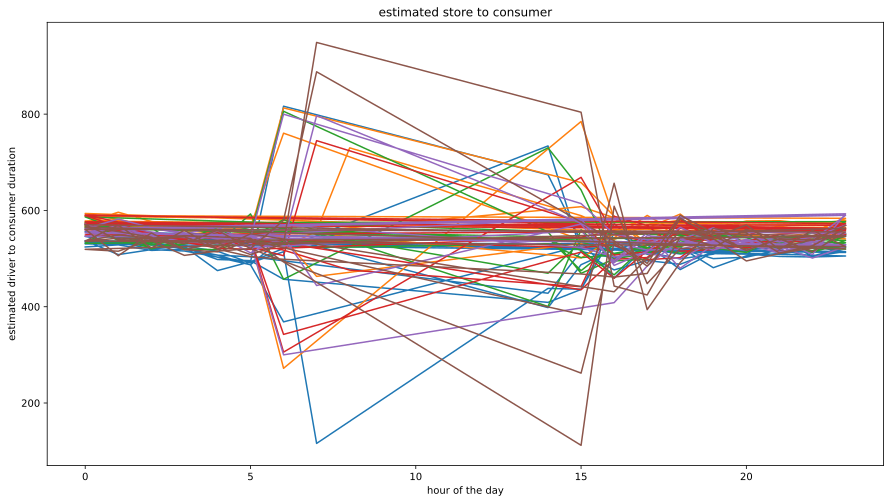

In [48]:
plt.figure(figsize=(15,8))

for market_id in store_to_consumer_grouped['market_id'].unique(): 
    
    marketis_data = store_to_consumer_grouped[store_to_consumer_grouped['market_id'] == market_id]

    plt.plot(marketis_data['hour'], marketis_data['estimated_store_to_consumer_driving_duration'])

plt.title('estimated store to consumer')
plt.xlabel('hour of the day')
plt.ylabel('estimated driver to consumer duration')

<Axes: >

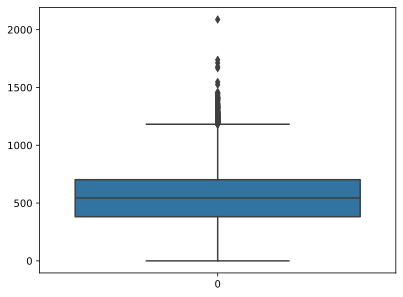

In [49]:
sns.boxplot(df['estimated_store_to_consumer_driving_duration'])

In [50]:
store_to_consumer_grouped[np.isinf(store_to_consumer_grouped)].sum().sum()

np.float64(0.0)

In [51]:
nulls_data(df)

,column,data type,number of nulls,precent null
0,estimated_store_to_consumer_driving_duration,float64,526,0.266430
1,actual_delivery_time,datetime64[ns],7,0.003546
2,actual_duration,float64,7,0.003546


In [52]:
# store_to_consumer_grouped = store_to_consumer_grouped.replace([np.inf, -np.inf], 0, inplace=True)

In [56]:
store_to_consumer_grouped

,market_id,day,hour,estimated_store_to_consumer_driving_duration
0,1.0,0,0,524.106942
1,1.0,0,1,528.473326
2,1.0,0,2,516.943269
3,1.0,0,3,519.660714
4,1.0,0,4,507.082803
...,...,...,...,...
678,6.0,6,19,553.409357
679,6.0,6,20,517.160622
680,6.0,6,21,541.211957
681,6.0,6,22,538.132812


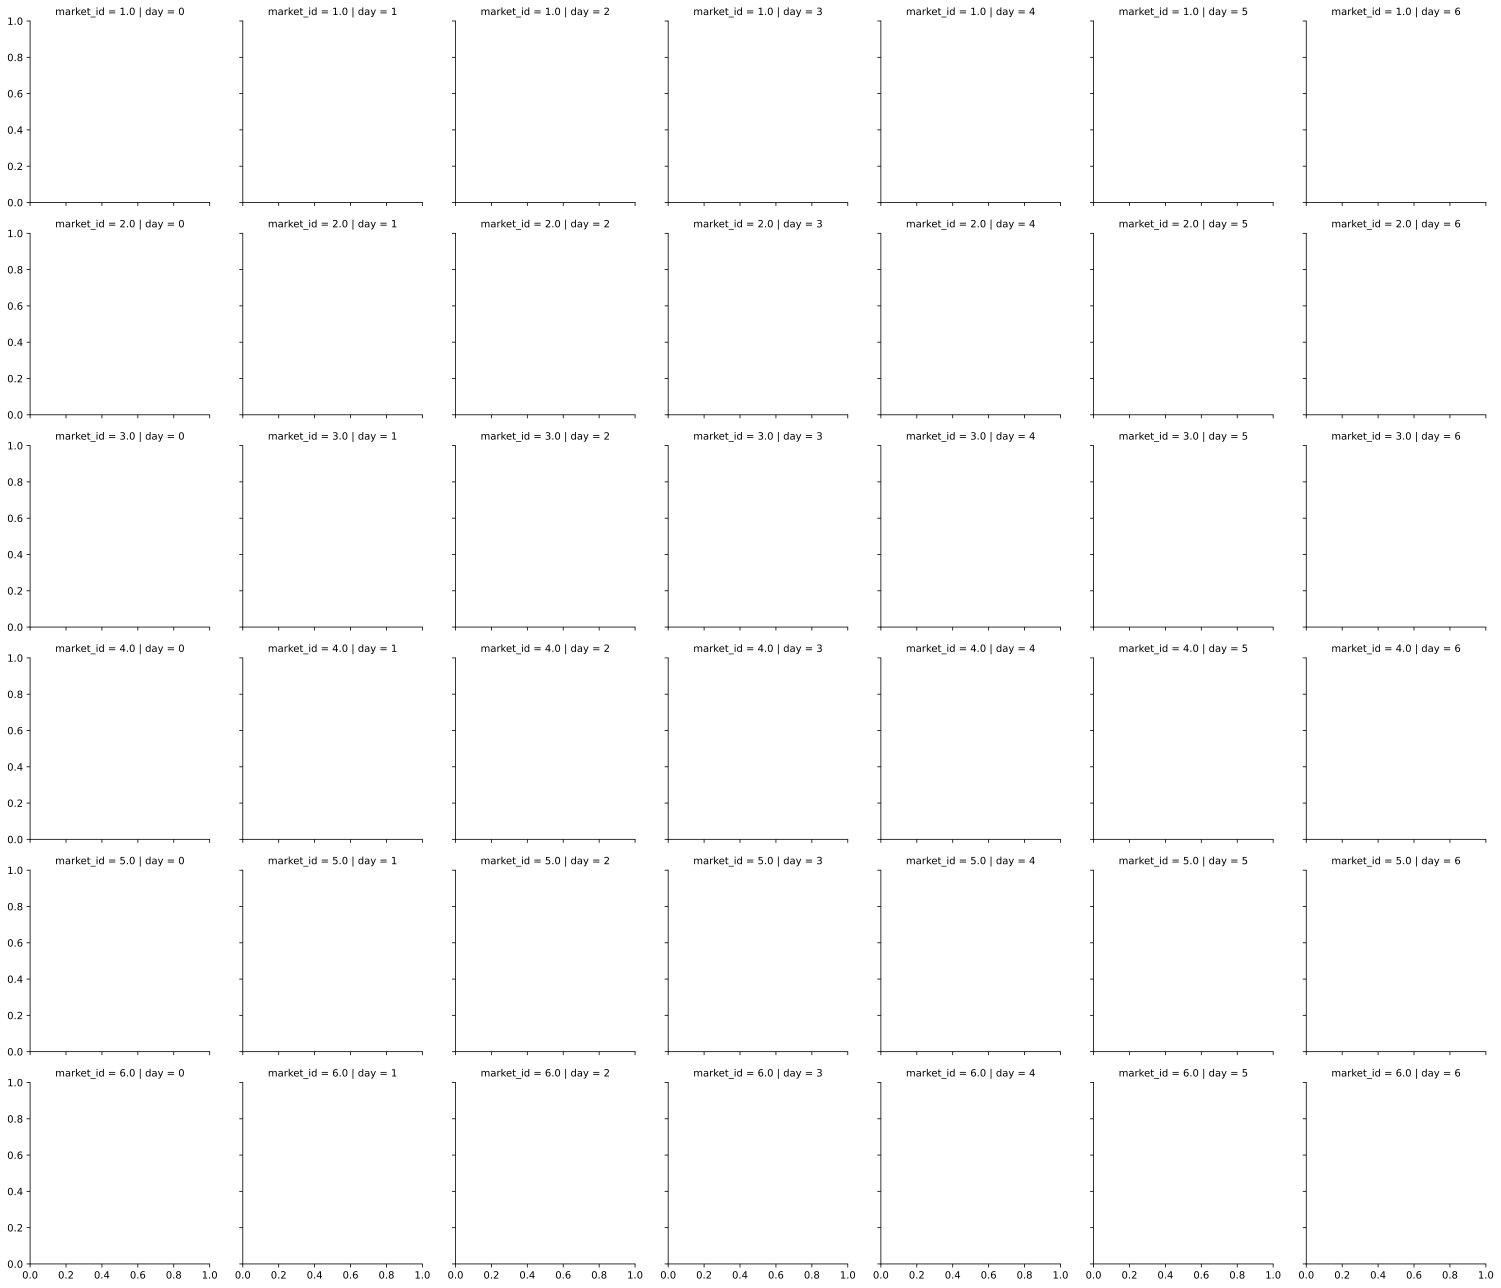

In [53]:
#day_market = sns.FacetGrid(store_to_consumer_grouped, col='day', row='market_id')

In [55]:
#day_market.map(sns.lineplot, 'hour', 'estimated_store_to_consumer_driving_duration', color='blue')

/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

TypeError: object of type 'FacetGrid' has no len()

In [67]:
market1 = store_to_consumer_grouped[store_to_consumer_grouped['market_id'] == 1.0]

In [68]:
market1

,market_id,day,hour,estimated_store_to_consumer_driving_duration
0,1.0,0,0,524.106942
1,1.0,0,1,528.473326
2,1.0,0,2,516.943269
3,1.0,0,3,519.660714
4,1.0,0,4,507.082803
...,...,...,...,...
113,1.0,6,19,513.902597
114,1.0,6,20,534.682578
115,1.0,6,21,518.051576
116,1.0,6,22,538.088068


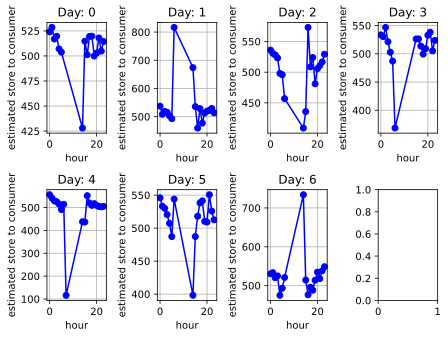

In [70]:
fig, axes = plt.subplots(2,4)


for i, day in enumerate(market1['day'].unique()): 
    
    ax = axes[i // 4, i % 4]

    day_data = market1[market1['day'] == day]
    ax.plot(day_data['hour'], day_data['estimated_store_to_consumer_driving_duration'], marker='o', linestyle = '-', color='blue')

    ax.set_title(f'Day: {day}')
    ax.set_xlabel('hour')
    ax.set_ylabel('estimated store to consumer')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [77]:
market1 = df[df['market_id'] == 1.0].groupby(['day', 'hour'])['estimated_store_to_consumer_driving_duration'].agg(pd.Series.mean).unstack()

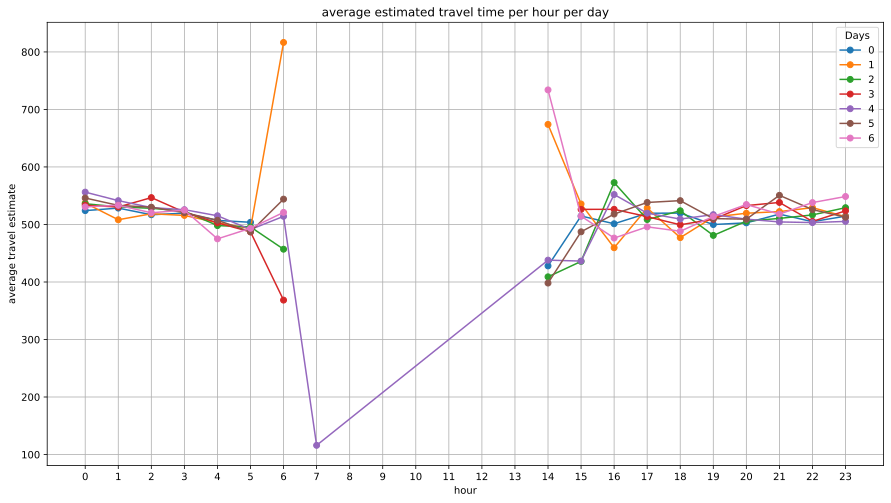

In [80]:
plt.figure(figsize=(15, 8))

for day in market1.index:

    market1.loc[day].plot(kind='line', marker='o', label=f'{day}')

plt.title('average estimated travel time per hour per day')
plt.xlabel('hour')
plt.ylabel('average travel estimate')
plt.xticks(range(24)) 
plt.grid(True)
plt.legend(title="Days")
plt.show()

#### store to consumer nulls

In [83]:
df.dropna().groupby(['market_id', 'day', 'hour'])['estimated_store_to_consumer_driving_duration'].agg(pd.Series.mean).reset_index()

,market_id,day,hour,estimated_store_to_consumer_driving_duration
0,1.0,0,0,524.106942
1,1.0,0,1,528.473326
2,1.0,0,2,516.943269
3,1.0,0,3,519.660714
4,1.0,0,4,507.082803
...,...,...,...,...
678,6.0,6,19,553.409357
679,6.0,6,20,517.160622
680,6.0,6,21,541.211957
681,6.0,6,22,538.132812


In [93]:
df.loc[:, 'estimated_store_to_consumer_driving_duration'] = df.groupby(['market_id', 'day', 'hour'])['estimated_store_to_consumer_driving_duration'].transform(lambda x: x.fillna(x.mean()))

In [95]:
df = df.dropna()